In [1]:
from src.generate_data import Data
from src.evaluate import *
from src.models import *

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
%autosave 120

Autosaving every 120 seconds


# Get the synthetic dataset

In [4]:
%%time
data = Data(layer_size=16, interop_distances=[0,1,2], permutation_intervals=2)

C:\Users\Luna Santos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


CPU times: total: 2.47 s
Wall time: 2.87 s


In [5]:
%%time
train, val, test = data.get_splits(['1st_interval', 'omit_distances'], [[0, 2]])

train_unshuffled = train.copy()
np.random.shuffle(train)

x_train, y_train = data.get_x_y(train)
x_val, y_val = data.get_x_y(val)
x_test, y_test = data.get_x_y(test)

train_original = data.reverse_encoding(data.get_x_y(train_unshuffled)[0])
val_original = data.reverse_encoding(x_val)
test_original = data.reverse_encoding(x_test)

Number of samples: 1293 train | 662 val | 2648 test
CPU times: total: 1min 9s
Wall time: 1min 12s


#### Peek at unshuffled train data

In [6]:
train_original[:20]

[['.,.,..,._._..__.', 'w__.____._.__,,,', 'c_r,_..,,_..,_,_', False],
 [',,,_,___.,._,___', 'w_,_,,,,.,,,.,__', ',c_r,,____.,,._,', False],
 ['_.,,_,,.,______,', 'w__,_._.,._,,__,', ',,c_r__,,..._,.,', False],
 ['._...__..,,..,_.', 'w.___.,._.__,.._', '._.c,r,,___..__,', False],
 ['._,..,,.__.._.__', 'w..,_..__._,__.,', '.,,_c.r,.._,_,..', False],
 ['.._._,__,_,_.,,,', 'w,,.__.___..___.', ',_._,c.r.,,_,_.,', False],
 ['_,_,,,_.,,.__,__', 'w.,._,__,..,_,.,', '.,,,,_c,r,,_....', False],
 ['_._,..,,.___..,,', '.w,..,_,._._,,_.', 'c.r_,,..,__.,.,,', False],
 ['.,,,,_._,_...._,', '_w._.__._,,__,_,', '.c,r_.,.,,_.,...', False],
 ['...,..,,_.,.._,.', '.w,,_.,.,.,_,_,.', '__c_r,_.,_,.,.._', False],
 ['_.__..,,.,,.__,,', '.w,.,_.,,.,.,..,', '._,c,r.,._,._,._', False],
 ['__,.__.,,._,.__.', ',w.._,.__.,._.._', '.,._c_r__._,.,._', False],
 ['_,_,,__.,,.__,..', ',w_.____.._,__,.', '_.,,,c,r,,...,.,', False],
 ['.,,.,_,.__._._._', '.w,._,._,.__,__.', ',.,.,,c.r,_,..._', False],
 ['....,.,.,,_._.,.'

In [7]:
pos_train_ratio = get_stats_and_ratio(train_original)

Number of samples by case:
F3 dr:    F2-wu 49 | F2-uw 49 | F2-w 49 | F2-noop 56 | 
F3 cr:    F2-wu 49 | F2-uw 49 | F2-w 49 | F2-noop 56 | 
F3 r:    F2-wu 49 | F2-uw 49 | F2-w 162 | F2-noop 169 | 
F3 noop:    F2-wu 56 | F2-uw 56 | F2-w 169 | F2-noop 177 | 

Positive samples count: 583
Total samples count: 1293
Positive class ratio: 0.4508894044856922


#### Peek at test data

In [8]:
test_original[:15]

[['..___,_._,,,....', '.,_,_,_,,,,uw_,.', '._,.___..._,,_.r', True],
 ['_,_._,._.,.__.,.', '._.,._..,,_,w.,,', '.,._,.__.,_,.___', False],
 [',,_____,.,..,__,', '_._.,,,.__,w_,u,', '__.,,.__..d,.r,,', False],
 ['..,..,_.._,_,...', ',_wu.,,,___,_,_.', ',,_._r.,___.,,_,', True],
 ['.,.__..,,,,_,,,_', ',..__,_._wu.,,_.', '_,,_...,,_.r__..', True],
 ['__,.___.,,__,.,.', ',._._u..w._,_,.,', '__,r,.._,_.,__..', True],
 [',,,__..,.,..__._', '__..,,___.,,.w__', '._.._.,.._.,.,.,', False],
 [',_._,,..,_,___._', ',,_.....,_.,uw..', '..__,.._,_.._,cr', False],
 [',_.,...,__,,._,.', '..._,_.,__.w,__.', '_._.,.,_.,,,c.,r', False],
 ['._,_,,._._..____', '.,___uw...,...,,', ',,..,__r__,,.._,', True],
 ['._,_,,_,_..._.,.', ',_.,..,.___,._,,', '._..,_,,,._,,r..', True],
 ['.,,__..,,,__,_..', '_.,._.,w..u,.,,.', '_...,....r__,.._', True],
 ['.,,...,..__,_.._', '_,..__._____.uw,', '.,._,,..,..,,r..', True],
 ['_.,,,,_._._.__..', ',,_,_,,,._,_..__', '_,._.._,,_,..cr.', False],
 ['_.__,,,_,,..,.,.', ',..,,

In [9]:
pos_test_ratio = get_stats_and_ratio(test_original)

Number of samples by case:
F3 dr:    F2-wu 155 | F2-uw 172 | F2-w 166 | F2-noop 170 | 
F3 cr:    F2-wu 168 | F2-uw 148 | F2-w 174 | F2-noop 178 | 
F3 r:    F2-wu 174 | F2-uw 173 | F2-w 148 | F2-noop 156 | 
F3 noop:    F2-wu 187 | F2-uw 168 | F2-w 143 | F2-noop 168 | 

Positive samples count: 1159
Total samples count: 2648
Positive class ratio: 0.43768882175226587


#### Peek at val data

In [10]:
val_original[:15]

[[',..._..,_._,._,.', '_,,____w___.___.', ',_.,,,,,__._._.,', False],
 [',__,_,__,.,._..,', '_,,,,.......,_,,', '__.,._,,,_,..__.', False],
 ['_._.__._...._.__', '.__,.__._...__._', '__.__,,.,,r,._..', True],
 [',..,.._,__._._._', ',_._,___.._.,,w,', '._,_._,.,r._.,__', True],
 ['__.,._,,.______,', '.w..._.._.,_..__', ',d.,r_,._,_,.,._', True],
 ['_,,.,_,._,,____.', '___..._,_,,u__w_', '.,_._,._c_,r_,,,', False],
 [',..._,._,....,.,', ',,_,_,.,,...____', '..dr_..,.___,_._', True],
 [',._,_,.,._,_,,.,', '..,,,._..,___._.', ',_,,,,.,_,d..r,,', True],
 ['_,,,.,_.,_,_.,,,', '__,.,_.,u._w,_,_', ',.,,__.,.,_,_._,', False],
 ['_,,_,___._,__,,_', '_,,,,__,_,,.__,,', '.,_,,_...d__r_..', True],
 ['..,._._,.._.,_..', '..,,,._,.,.w.,_.', '_.,.,_.,_,_.._,.', False],
 [',,.,_,,,_._.,..,', ',.,__,.,_w_.__._', '..,,,__...._.,dr', True],
 ['..,,..._,,_.,,..', '..,...,._..__...', ',_..d..r.,_,__.,', True],
 ['.._...._,,_,_.,,', '._w,,....,._,.__', ',cr_,.__.._,_,..', False],
 [',,.__,,__.__..,_', '_.,__

In [11]:
pos_val_ratio = get_stats_and_ratio(val_original)

Number of samples by case:
F3 dr:    F2-wu 43 | F2-uw 26 | F2-w 45 | F2-noop 56 | 
F3 cr:    F2-wu 30 | F2-uw 50 | F2-w 37 | F2-noop 48 | 
F3 r:    F2-wu 37 | F2-uw 38 | F2-w 29 | F2-noop 36 | 
F3 noop:    F2-wu 39 | F2-uw 58 | F2-w 49 | F2-noop 41 | 

Positive samples count: 267
Total samples count: 662
Positive class ratio: 0.4033232628398791


#### Send label arrays to device

In [12]:
y_train = torch.from_numpy(y_train.astype(float)).float().to(device)
y_val = torch.from_numpy(y_val.astype(float)).float().to(device)
y_test = torch.from_numpy(y_test.astype(float)).float().to(device)

#### Get data in normal format (same as CNN format)

In [13]:
x_train_normal = data.to_conv_format(x_train)
x_val_normal = data.to_conv_format(x_val)
x_test_normal = data.to_conv_format(x_test)
for i in range(len(x_train_normal)):
    x_train_normal[i] = x_train_normal[i].to(device)
    x_val_normal[i] = x_val_normal[i].to(device)
    x_test_normal[i] = x_test_normal[i].to(device)

In [14]:
x_train_normal[0].shape

torch.Size([1293, 128])

#### Get data in convolutional format, send to device

In [15]:
x_train_cnn = data.to_conv_format(x_train, padding_left_size=2, padding_right_size=2)
x_val_cnn = data.to_conv_format(x_val, padding_left_size=2, padding_right_size=2)
x_test_cnn = data.to_conv_format(x_test, padding_left_size=2, padding_right_size=2)
for i in range(len(x_train_cnn)):
    x_train_cnn[i] = x_train_cnn[i].to(device)
    x_val_cnn[i] = x_val_cnn[i].to(device)
    x_test_cnn[i] = x_test_cnn[i].to(device)

In [16]:
x_train_cnn[0].shape

torch.Size([1293, 160])

#### Get data in LSTM format, send to device

In [17]:
x_train_lstm = data.to_lstm_format(x_train, padding_left_size=2, padding_right_size=0)
x_val_lstm = data.to_lstm_format(x_val, padding_left_size=0, padding_right_size=2)
x_test_lstm = data.to_lstm_format(x_test, padding_left_size=0, padding_right_size=2)
for i in range(len(x_train_lstm)):
    x_train_lstm[i] = x_train_lstm[i].to(device)
    x_val_lstm[i] = x_val_lstm[i].to(device)
    x_test_lstm[i] = x_test_lstm[i].to(device)

In [18]:
x_train_lstm[0].shape

torch.Size([1293, 18, 8])

### Define training parameters

In [19]:
num_experiments = 20
epochs = 200
early_stopping_limit = 100

experiment_name = "f2_f4_redo"

### Define training procedure for each model

In [20]:
def train_models(constructor, x_train, x_val, x_test, weight_decay, *argv):
    accuracies = [] #lista con la precisión de cada modelo en el cjto de prueba
    precisions = []
    recalls = []
    f1_scores = []
    wrong_preds = []#lista con las predicciones incorrectas del modelo en el cjto de prueba
    best_accuracy = 0
    
    #listas de listas de cada modelo durante el entrenamiento y prueba
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for i in range(num_experiments):
        model = constructor(*argv)
        model.to(device)

        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([(1-pos_train_ratio)/pos_train_ratio]).to(device))
        optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay)

        train_losses.append([])
        val_losses.append([])
        train_accs.append([])
        val_accs.append([])
        
        best_acc = 0

        early_stopping_cnt = 0

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = train_epoch(model, x_train, y_train, criterion, optimizer, epoch, 10, verbose=False)
            val_loss, val_acc = eval_epoch(model, x_val, y_val, criterion, 'Validation', verbose=False)

            
            train_losses[-1].append(train_loss)
            val_losses[-1].append(val_loss)
            train_accs[-1].append(train_acc)
            val_accs[-1].append(val_acc)
            
            model_name = constructor.__name__[:constructor.__name__.find('_')]
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), f'./{model_name}_model_TEMP_' + experiment_name)    
                early_stopping_cnt = 0
            else:
                early_stopping_cnt += 1

            if early_stopping_cnt >= early_stopping_limit:
                break

        model.load_state_dict(torch.load(f'./{model_name}_model_TEMP_' + experiment_name))

        accuracies.append(get_accuracy_by_cases(model, x_test, y_test, test_original)) #Se evalúa el modelo en el conjunto de prueba 
        precisions.append(get_precision(model, x_test, y_test, test_original))
        recalls.append(get_recall(model, x_test, y_test, test_original))
        f1_scores.append(get_f1(precisions[-1], recalls[-1]))        
        
        wrong_preds.append(get_wrong_predictions(model, x_test, y_test, test_original))

        if accuracies[-1]['Overall'] > best_accuracy:
            torch.save(model.state_dict(), f'./best_{model_name}_model_' + experiment_name)    
            best_accuracy = accuracies[-1]['Overall']

        print(i + 1, "/", num_experiments, "models trained | Current model best validation accuracy:", best_accuracy)

    return accuracies, precisions, recalls, f1_scores,  wrong_preds, [train_losses, val_losses, train_accs, val_accs]

# Train models

In [21]:
%%time
cnn_accuracies, cnn_precisions, cnn_recall, cnn_f1_scores, cnn_wrong_preds, cnn_epoch_stats = train_models(CNN_Model, x_train_cnn, x_val_cnn, x_test_cnn, 0.005, data, 32, 64, 4, -1, 'keras')


1 / 20 models trained | Current model best validation accuracy: 0.6918429003021148
2 / 20 models trained | Current model best validation accuracy: 0.6918429003021148
3 / 20 models trained | Current model best validation accuracy: 0.7722809667673716
4 / 20 models trained | Current model best validation accuracy: 0.8255287009063444
5 / 20 models trained | Current model best validation accuracy: 0.834214501510574
6 / 20 models trained | Current model best validation accuracy: 0.834214501510574
7 / 20 models trained | Current model best validation accuracy: 0.834214501510574
8 / 20 models trained | Current model best validation accuracy: 0.834214501510574
9 / 20 models trained | Current model best validation accuracy: 0.834214501510574
10 / 20 models trained | Current model best validation accuracy: 0.9233383685800605
11 / 20 models trained | Current model best validation accuracy: 0.9233383685800605
12 / 20 models trained | Current model best validation accuracy: 0.9233383685800605
13 / 2

In [22]:
%%time
lstm_accuracies, lstm_precisions, lstm_recall, lstm_f1_scores, lstm_wrong_preds, lstm_epoch_stats = train_models(LSTM_Model, x_train_lstm, x_val_lstm, x_test_lstm, 0.0001, data, 16, 32, 8, 'keras')

1 / 20 models trained | Current model best validation accuracy: 0.9558157099697885
2 / 20 models trained | Current model best validation accuracy: 0.9765861027190332
3 / 20 models trained | Current model best validation accuracy: 0.9765861027190332
4 / 20 models trained | Current model best validation accuracy: 0.9799848942598187
5 / 20 models trained | Current model best validation accuracy: 0.9799848942598187
6 / 20 models trained | Current model best validation accuracy: 0.9799848942598187
7 / 20 models trained | Current model best validation accuracy: 0.9928247734138973
8 / 20 models trained | Current model best validation accuracy: 0.9928247734138973
9 / 20 models trained | Current model best validation accuracy: 0.9928247734138973
10 / 20 models trained | Current model best validation accuracy: 0.9928247734138973
11 / 20 models trained | Current model best validation accuracy: 0.9928247734138973
12 / 20 models trained | Current model best validation accuracy: 0.9928247734138973
1

In [23]:
%%time
deepset_accuracies, deepset_precisions, deepset_recall, deepset_f1_scores,deepset_wrong_preds, deepset_epoch_stats = train_models(DEEPSET_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

1 / 20 models trained | Current model best validation accuracy: 0.6880664652567976
2 / 20 models trained | Current model best validation accuracy: 0.7009063444108762
3 / 20 models trained | Current model best validation accuracy: 0.7009063444108762
4 / 20 models trained | Current model best validation accuracy: 0.7009063444108762
5 / 20 models trained | Current model best validation accuracy: 0.7009063444108762
6 / 20 models trained | Current model best validation accuracy: 0.7009063444108762
7 / 20 models trained | Current model best validation accuracy: 0.7009063444108762
8 / 20 models trained | Current model best validation accuracy: 0.7009063444108762
9 / 20 models trained | Current model best validation accuracy: 0.7009063444108762
10 / 20 models trained | Current model best validation accuracy: 0.7009063444108762
11 / 20 models trained | Current model best validation accuracy: 0.7009063444108762
12 / 20 models trained | Current model best validation accuracy: 0.7009063444108762
1

In [24]:
%%time
deepsetv2_accuracies, deepsetv2_precisions, deepsetv2_recall, deepsetv2_f1_scores, deepsetv2_wrong_preds, deepsetv2_epoch_stats = train_models(DEEPSETV2_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 32, 8, 'keras')

1 / 20 models trained | Current model best validation accuracy: 0.43768882175226587
2 / 20 models trained | Current model best validation accuracy: 0.43768882175226587
3 / 20 models trained | Current model best validation accuracy: 0.43768882175226587
4 / 20 models trained | Current model best validation accuracy: 0.43768882175226587
5 / 20 models trained | Current model best validation accuracy: 0.43768882175226587
6 / 20 models trained | Current model best validation accuracy: 0.43768882175226587
7 / 20 models trained | Current model best validation accuracy: 0.43768882175226587
8 / 20 models trained | Current model best validation accuracy: 0.43768882175226587
9 / 20 models trained | Current model best validation accuracy: 0.43768882175226587
10 / 20 models trained | Current model best validation accuracy: 0.43768882175226587
11 / 20 models trained | Current model best validation accuracy: 0.43768882175226587
12 / 20 models trained | Current model best validation accuracy: 0.4376888

In [25]:
%%time
feedforward_accuracies, feedforward_precisions, feedforward_recall, feedforward_f1_scores, feedforward_wrong_preds, feedforward_epoch_stats = train_models(FEEDFORWARD_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

1 / 20 models trained | Current model best validation accuracy: 0.6907099697885196
2 / 20 models trained | Current model best validation accuracy: 0.6978851963746223
3 / 20 models trained | Current model best validation accuracy: 0.6978851963746223
4 / 20 models trained | Current model best validation accuracy: 0.6978851963746223
5 / 20 models trained | Current model best validation accuracy: 0.6978851963746223
6 / 20 models trained | Current model best validation accuracy: 0.6978851963746223
7 / 20 models trained | Current model best validation accuracy: 0.6978851963746223
8 / 20 models trained | Current model best validation accuracy: 0.6978851963746223
9 / 20 models trained | Current model best validation accuracy: 0.6978851963746223
10 / 20 models trained | Current model best validation accuracy: 0.6978851963746223
11 / 20 models trained | Current model best validation accuracy: 0.6978851963746223
12 / 20 models trained | Current model best validation accuracy: 0.6978851963746223
1

# Evaluation

In [26]:
all_accuracies = [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies]
all_precisions = [cnn_precisions, lstm_precisions, deepset_precisions, deepsetv2_precisions, feedforward_precisions]
all_recalls = [cnn_recall, lstm_recall, deepset_recall, deepsetv2_recall, feedforward_recall]
all_f1_scores = [cnn_f1_scores, lstm_f1_scores, deepset_f1_scores, deepsetv2_f1_scores, feedforward_f1_scores]

model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']

In [27]:
get_summary_df(model_names, all_accuracies, all_precisions, all_recalls, all_f1_scores)

                   Modelo  Accuracy  Precision    Recall  F1-score
0                     CNN  0.941088   0.881369  1.000000  0.936944
1                    LSTM  0.992825   0.994792  0.988783  0.991778
2  DeepSet(like in paper)  0.700906   0.820244  0.405522  0.542725
3   DeepSet(sum at start)  0.437689   0.437689  1.000000  0.608878
4             Feedforward  0.697885   0.867076  0.365833  0.514563


## Accuracies per CNN model

In [28]:
get_stats_per_model(cnn_accuracies, ['CNN #' + str(i) for i in range(len(cnn_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
CNN #0,69.2%,1.0%,76.6%,100.0%,100.0%
CNN #1,68.9%,0.0%,76.6%,100.0%,100.0%
CNN #2,77.2%,32.9%,76.6%,100.0%,100.0%
CNN #3,82.6%,55.8%,76.6%,100.0%,98.2%
CNN #4,83.4%,57.5%,76.6%,100.0%,100.0%
CNN #5,68.9%,0.0%,76.6%,100.0%,100.0%
CNN #6,72.9%,15.9%,76.6%,100.0%,100.0%
CNN #7,69.8%,3.6%,76.6%,100.0%,100.0%
CNN #8,74.9%,23.7%,76.6%,100.0%,100.0%
CNN #9,92.3%,92.8%,76.6%,100.0%,100.0%


## Accuracies per LSTM model

In [29]:
get_stats_per_model(lstm_accuracies, ['LSTM #' + str(i) for i in range(len(lstm_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
LSTM #0,95.6%,100.0%,89.9%,100.0%,92.3%
LSTM #1,97.7%,100.0%,98.0%,100.0%,92.5%
LSTM #2,95.2%,99.0%,84.0%,100.0%,98.0%
LSTM #3,98.0%,100.0%,94.6%,100.0%,97.4%
LSTM #4,91.9%,100.0%,92.6%,100.0%,74.7%
LSTM #5,96.6%,100.0%,89.7%,100.0%,96.5%
LSTM #6,99.3%,99.7%,97.4%,100.0%,100.0%
LSTM #7,96.6%,100.0%,92.9%,100.0%,93.4%
LSTM #8,92.4%,100.0%,87.8%,100.0%,81.7%
LSTM #9,92.0%,100.0%,90.8%,100.0%,77.0%


## Accuracies per DeepSets V1 model

In [30]:
get_stats_per_model(deepset_accuracies, ['DeepSet(like in paper) #' + str(i) for i in range(len(deepset_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(like in paper) #0,68.8%,99.1%,46.2%,100.0%,28.9%
DeepSet(like in paper) #1,70.1%,96.4%,50.8%,100.0%,32.1%
DeepSet(like in paper) #2,68.7%,97.6%,47.2%,100.0%,28.9%
DeepSet(like in paper) #3,69.3%,99.6%,47.5%,100.0%,29.2%
DeepSet(like in paper) #4,69.5%,99.3%,48.4%,100.0%,29.2%
DeepSet(like in paper) #5,68.8%,98.4%,46.9%,100.0%,29.0%
DeepSet(like in paper) #6,69.2%,99.7%,48.0%,100.0%,28.0%
DeepSet(like in paper) #7,69.3%,99.6%,47.8%,100.0%,28.6%
DeepSet(like in paper) #8,69.6%,100.0%,48.0%,100.0%,29.3%
DeepSet(like in paper) #9,69.2%,99.4%,48.6%,100.0%,27.8%


## Accuracies per DeepSets V2 model

In [31]:
get_stats_per_model(deepsetv2_accuracies, ['DeepSet(sum at start) #' + str(i) for i in range(len(deepsetv2_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(sum at start) #0,43.8%,0.0%,76.6%,0.0%,100.0%
DeepSet(sum at start) #1,43.8%,0.0%,76.6%,0.0%,100.0%
DeepSet(sum at start) #2,43.8%,0.0%,76.6%,0.0%,100.0%
DeepSet(sum at start) #3,43.8%,0.0%,76.6%,0.0%,100.0%
DeepSet(sum at start) #4,43.8%,0.0%,76.6%,0.0%,100.0%
DeepSet(sum at start) #5,43.8%,0.0%,76.6%,0.0%,100.0%
DeepSet(sum at start) #6,43.8%,0.0%,76.6%,0.0%,100.0%
DeepSet(sum at start) #7,43.8%,0.0%,76.6%,0.0%,100.0%
DeepSet(sum at start) #8,43.8%,0.0%,76.6%,0.0%,100.0%
DeepSet(sum at start) #9,43.8%,0.0%,76.6%,0.0%,100.0%


## Accuracies per FeedForward model

In [32]:
get_stats_per_model(feedforward_accuracies, ['Feedforward #' + str(i) for i in range(len(feedforward_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
Feedforward #0,69.1%,98.5%,48.0%,100.0%,28.7%
Feedforward #1,69.8%,99.6%,48.9%,100.0%,29.6%
Feedforward #2,69.5%,99.6%,48.6%,100.0%,28.9%
Feedforward #3,68.8%,98.1%,46.6%,100.0%,29.5%
Feedforward #4,69.8%,99.9%,48.9%,100.0%,29.3%
Feedforward #5,69.3%,99.3%,48.4%,99.7%,28.7%
Feedforward #6,69.1%,98.5%,47.5%,99.8%,29.5%
Feedforward #7,69.0%,99.1%,46.6%,100.0%,29.0%
Feedforward #8,69.3%,98.5%,48.9%,99.8%,28.9%
Feedforward #9,69.0%,97.3%,48.6%,99.8%,29.2%


# Training evolution

### CNN

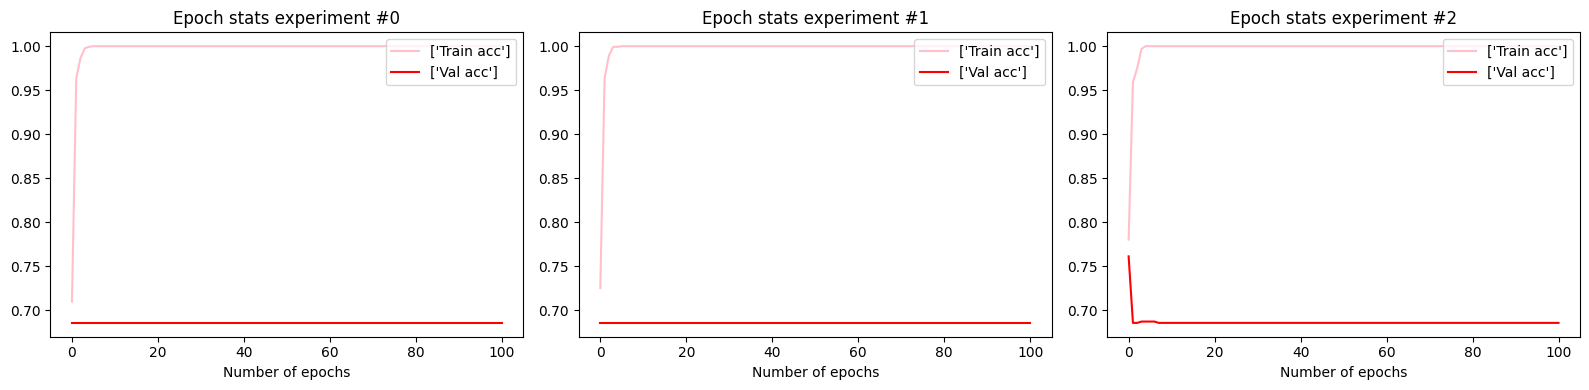

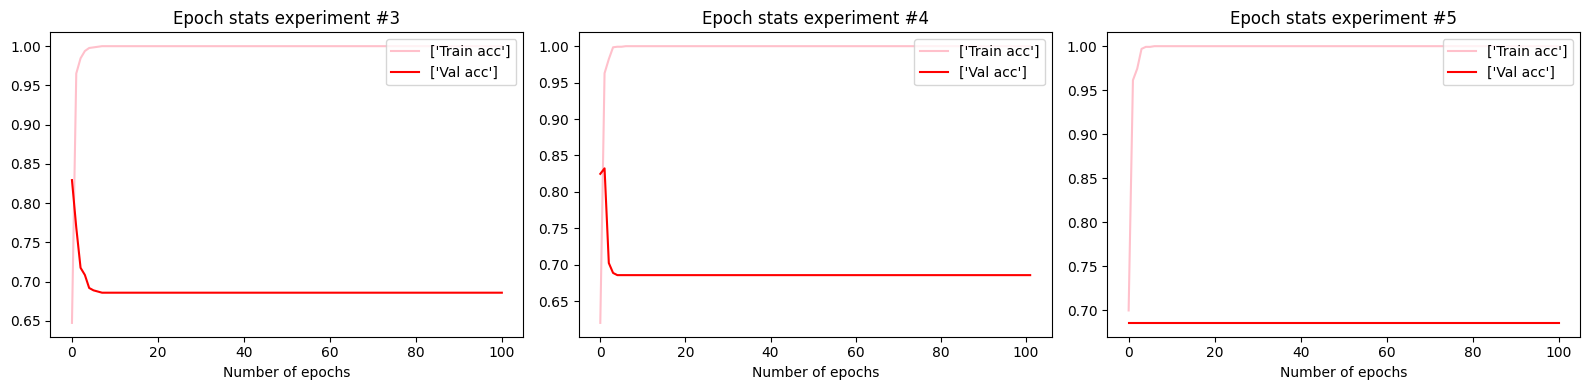

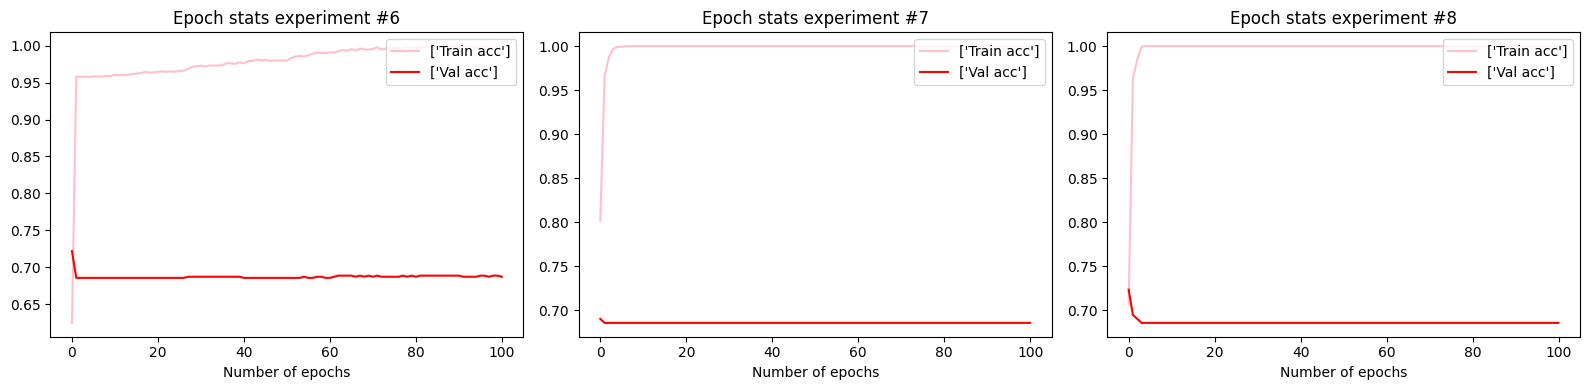

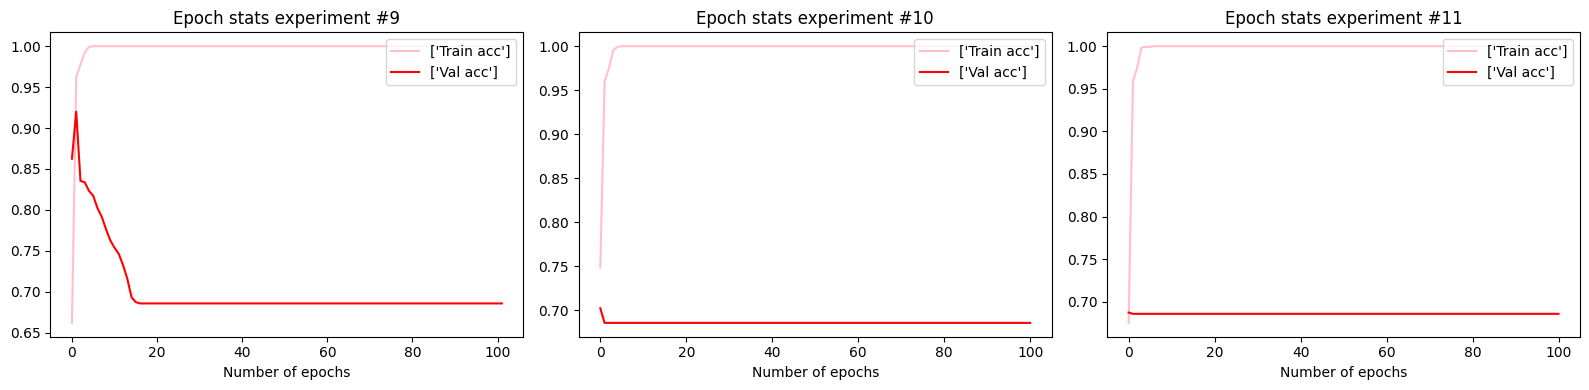

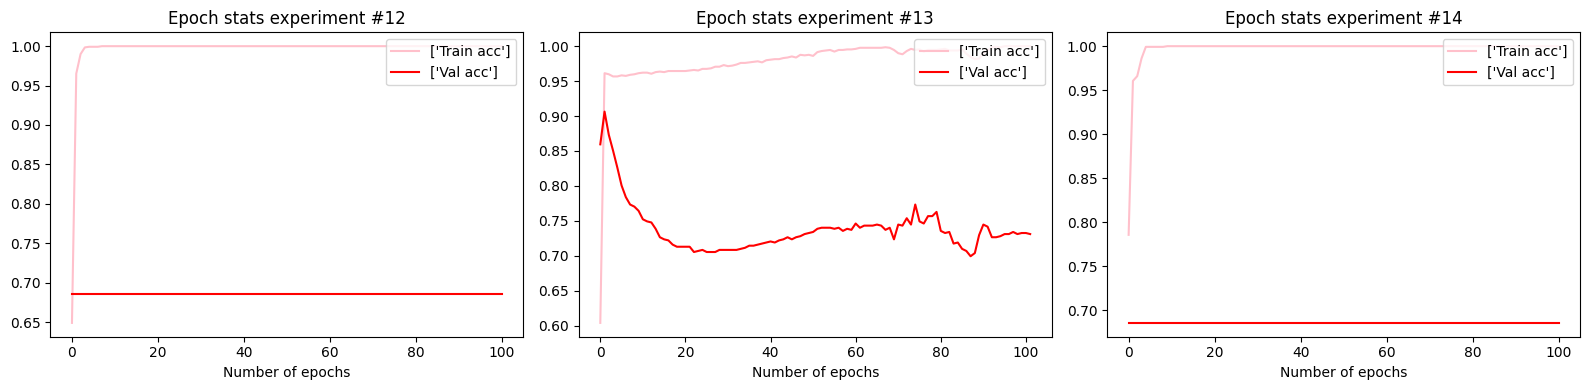

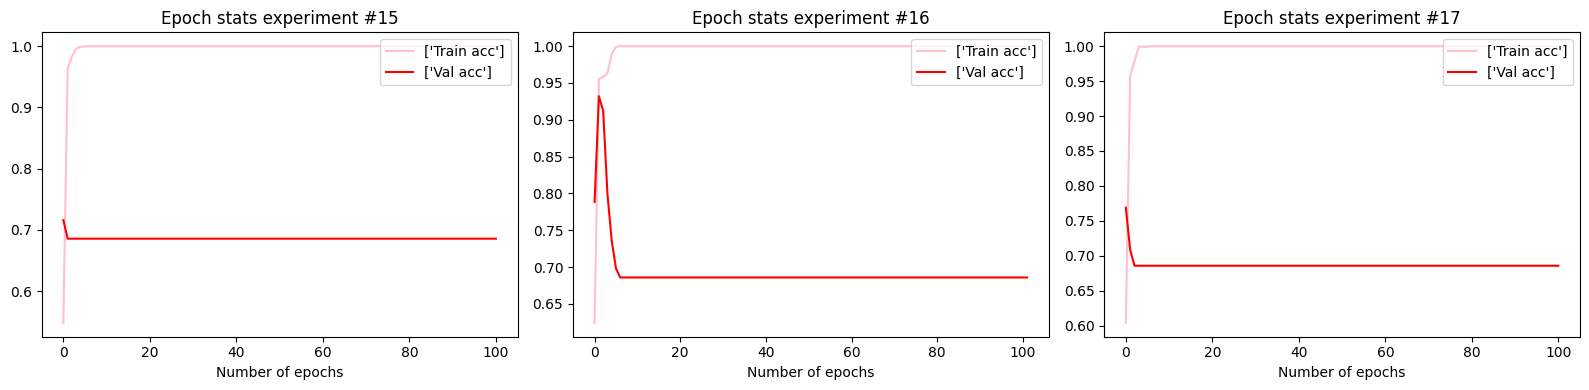

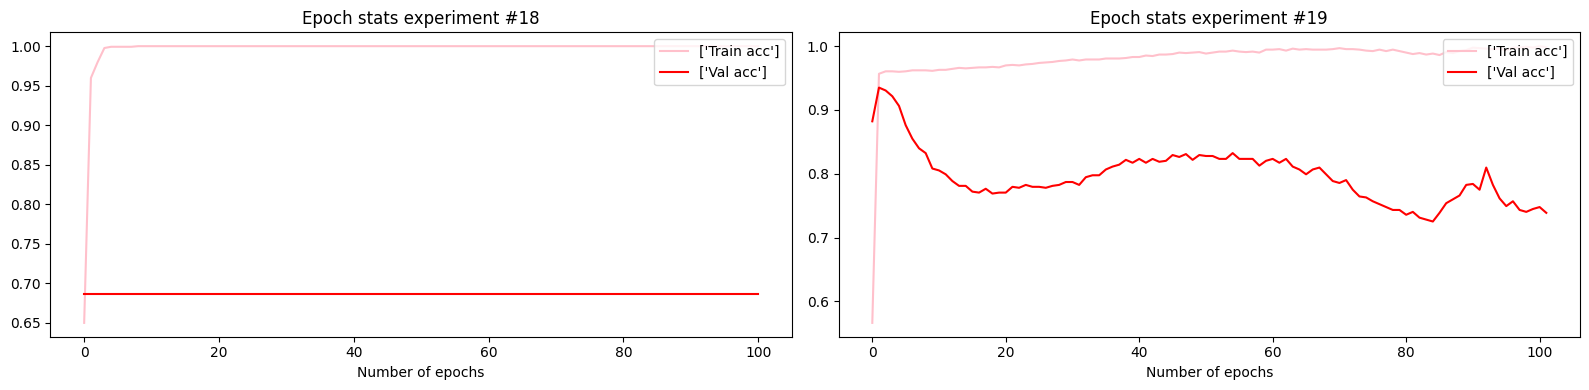

In [33]:
display_epochs_stats(cnn_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### LSTM

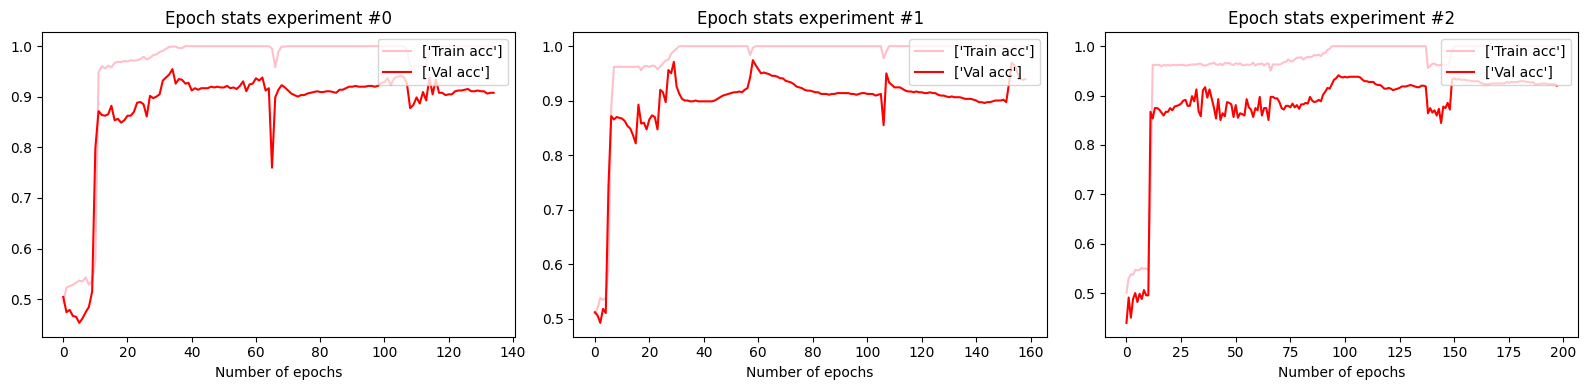

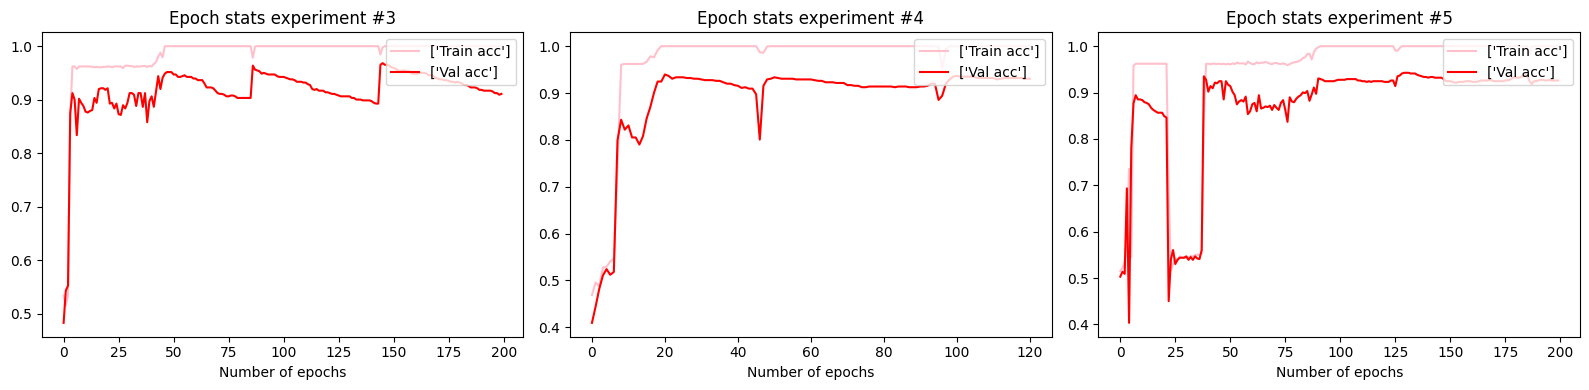

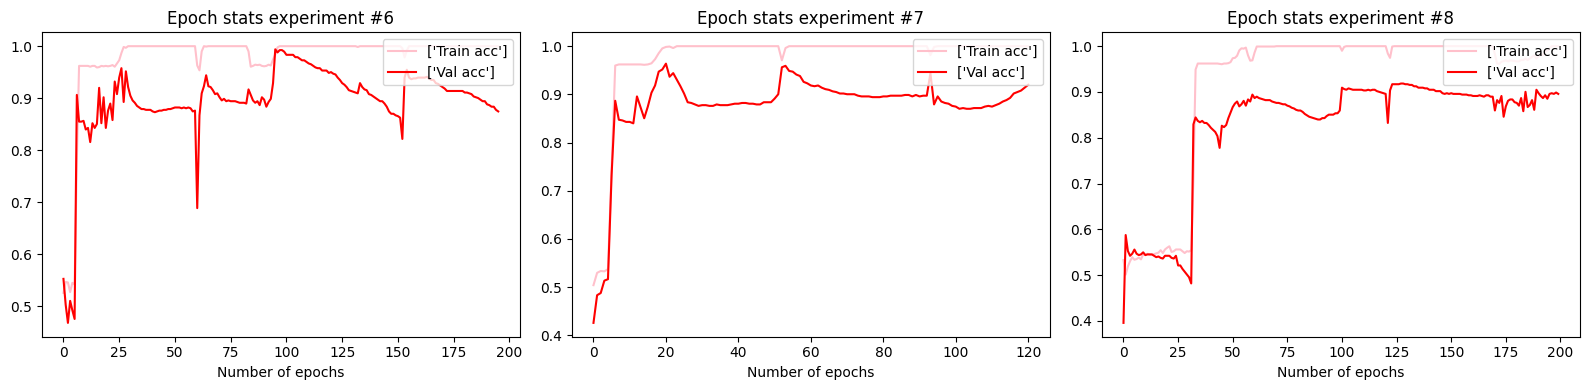

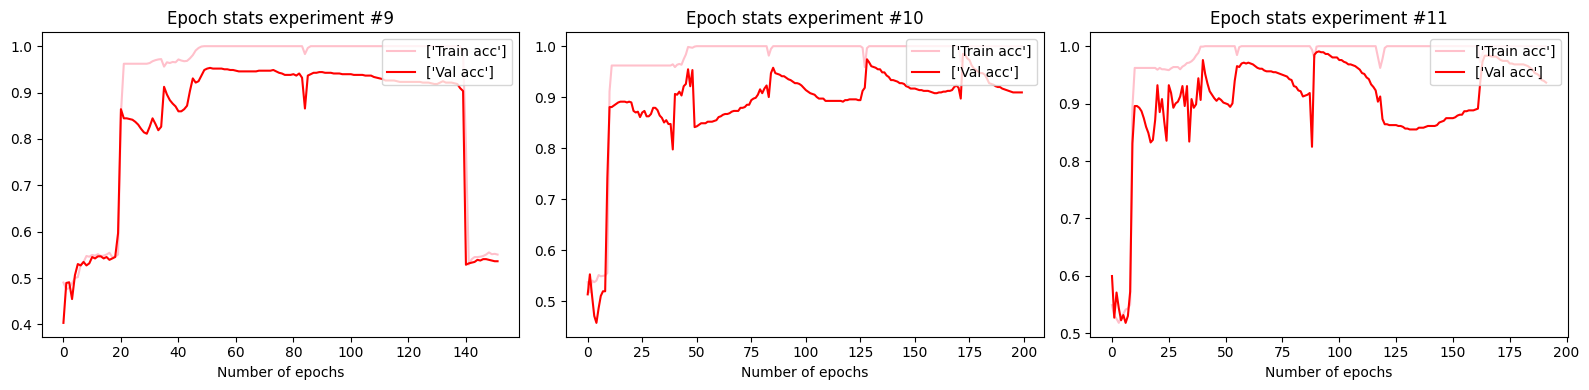

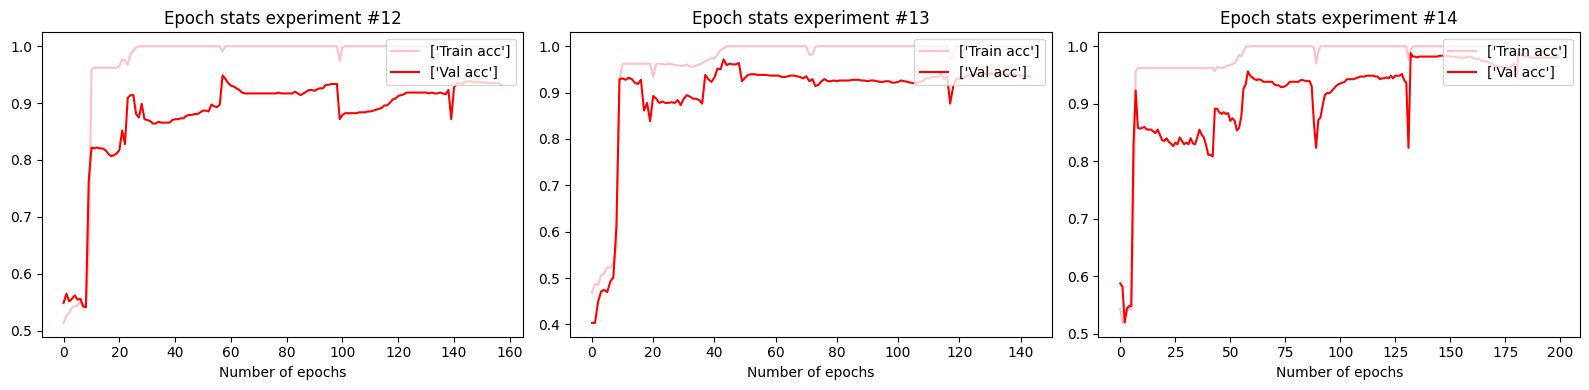

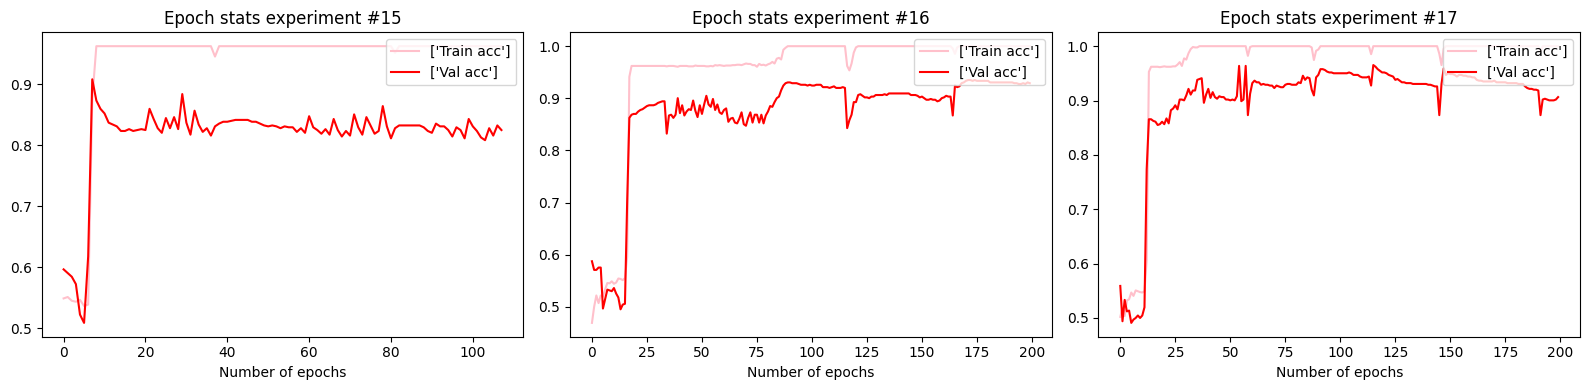

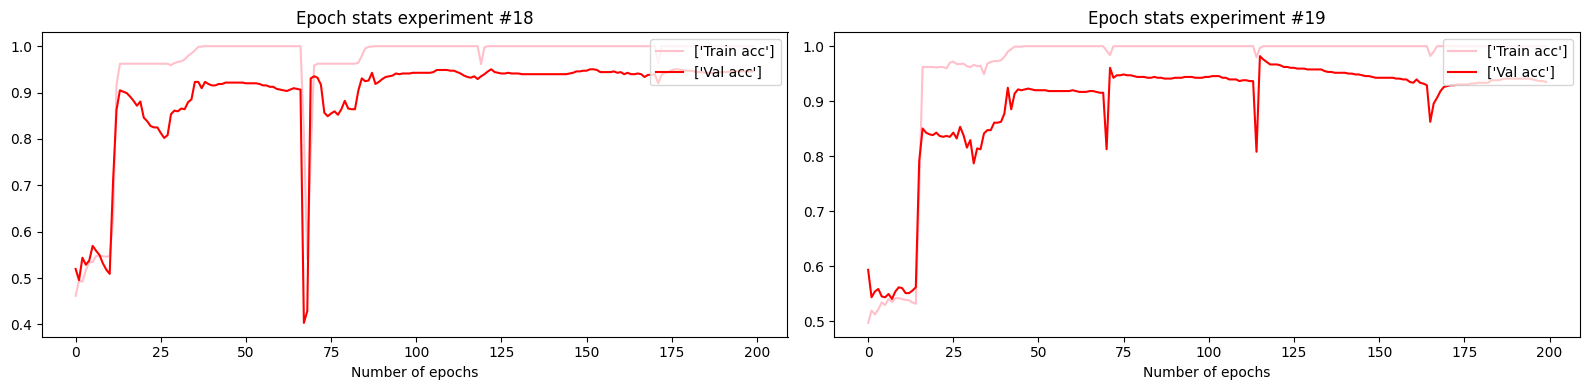

In [34]:
display_epochs_stats(lstm_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V1

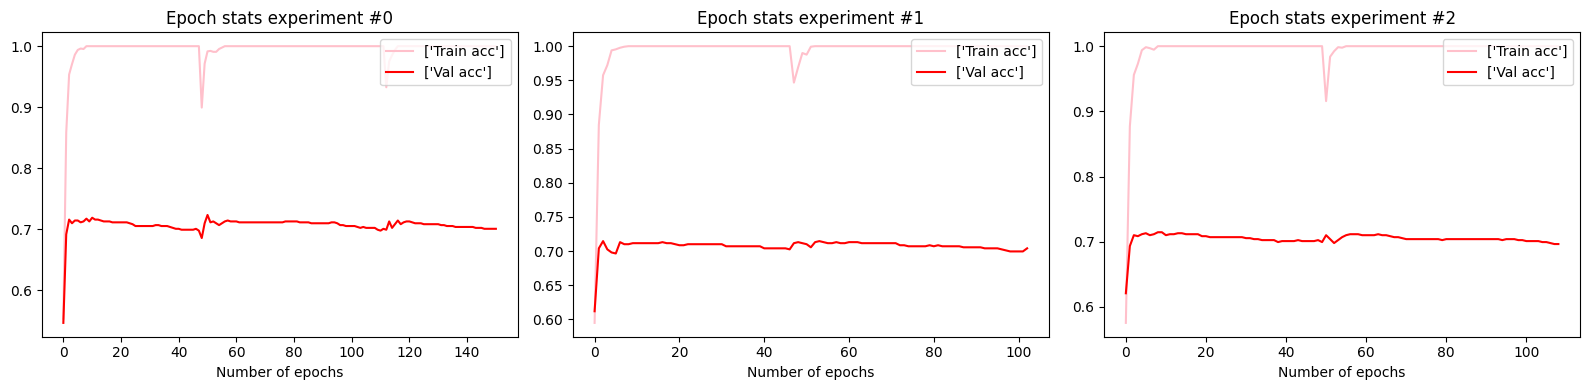

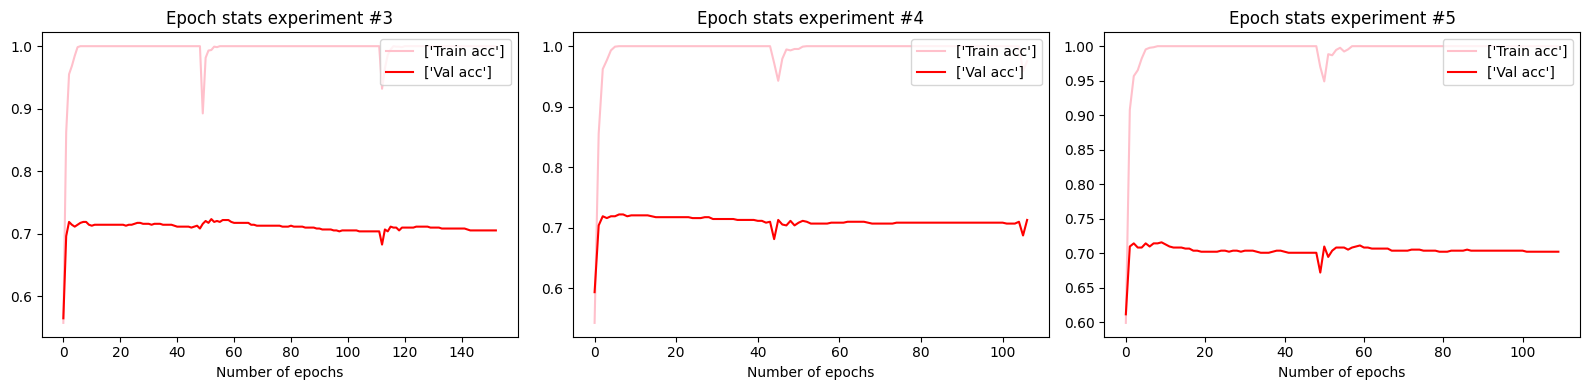

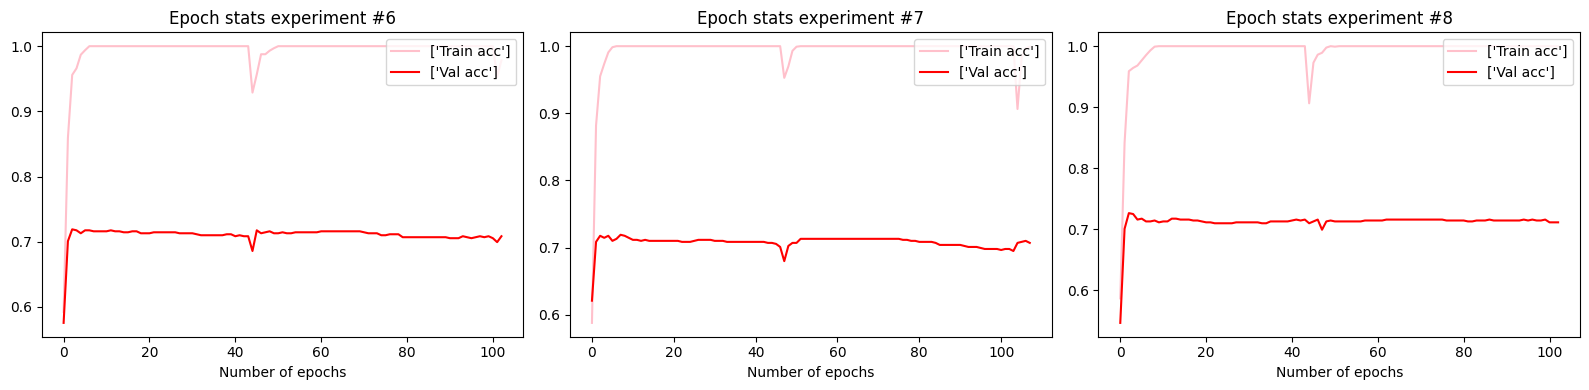

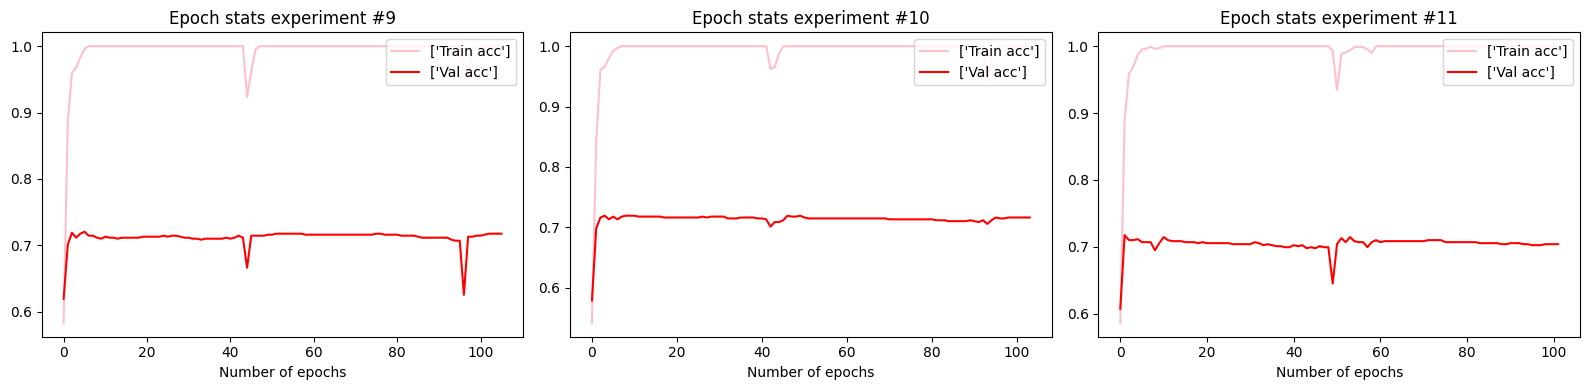

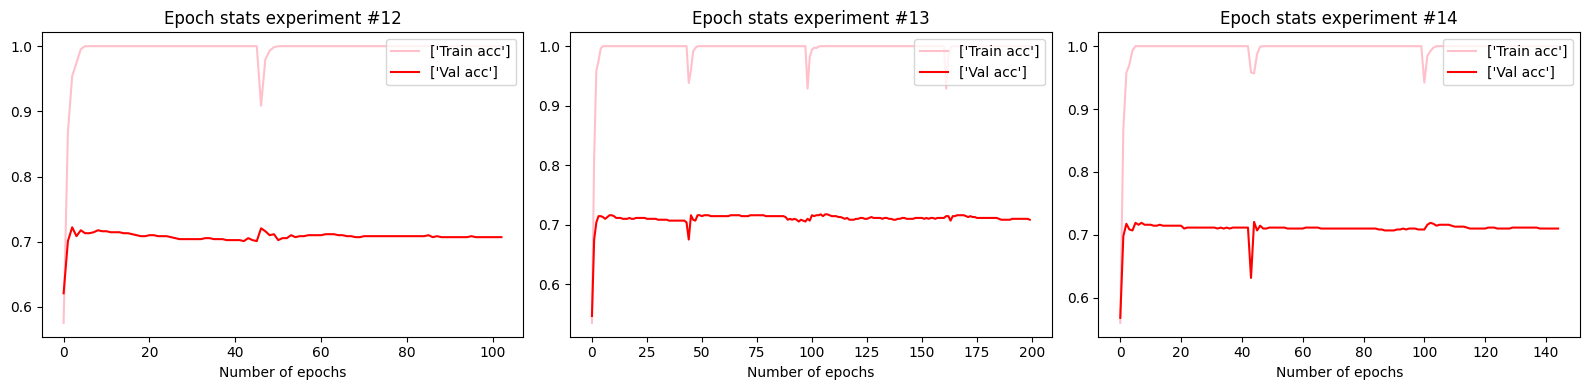

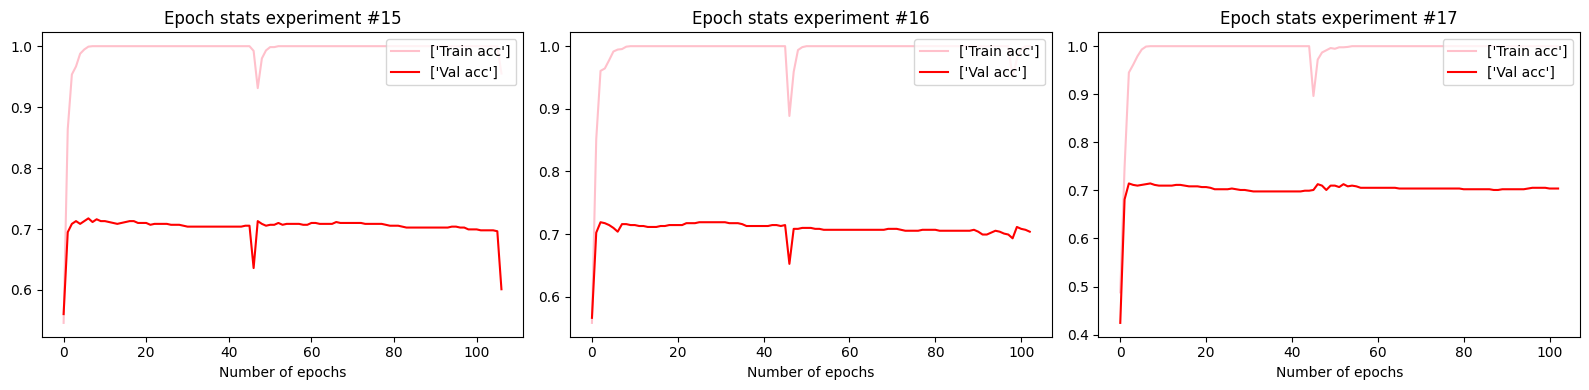

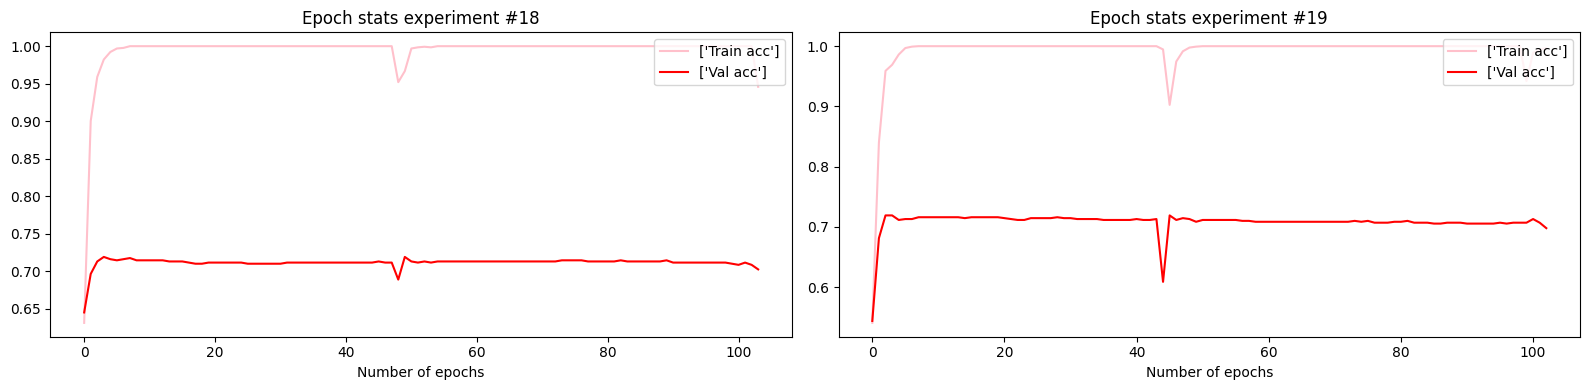

In [35]:
display_epochs_stats(deepset_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V2

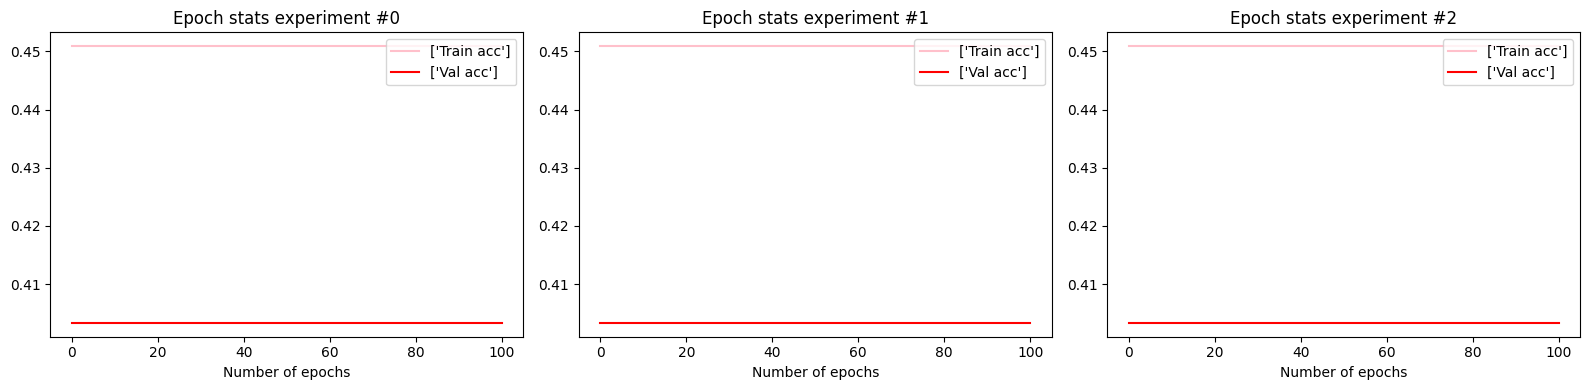

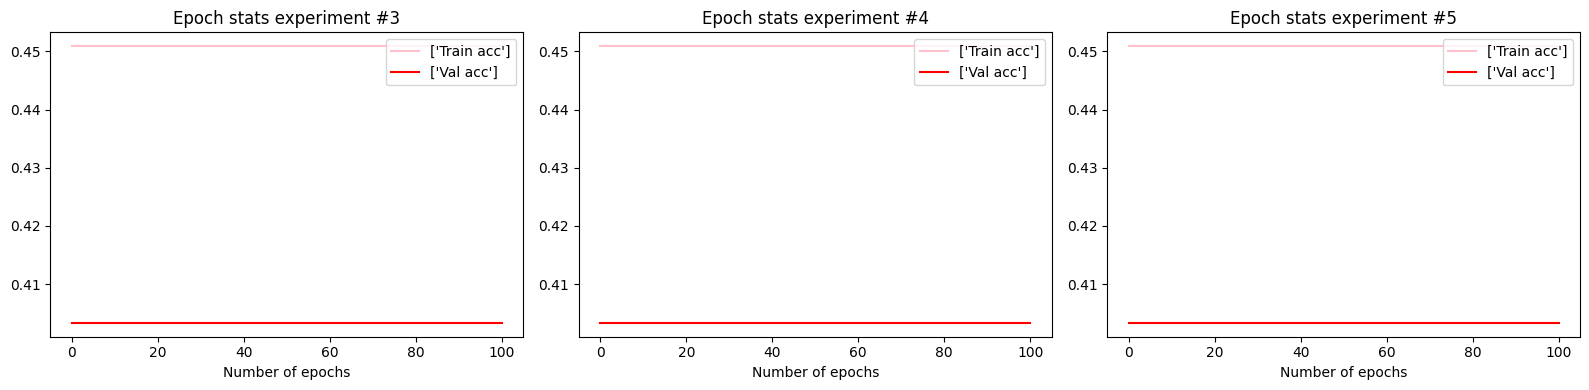

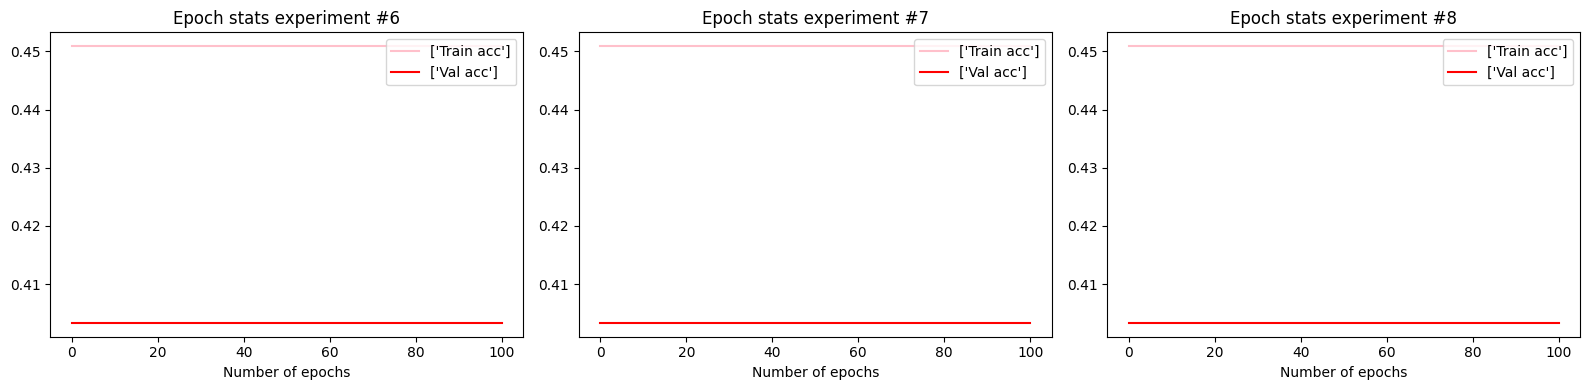

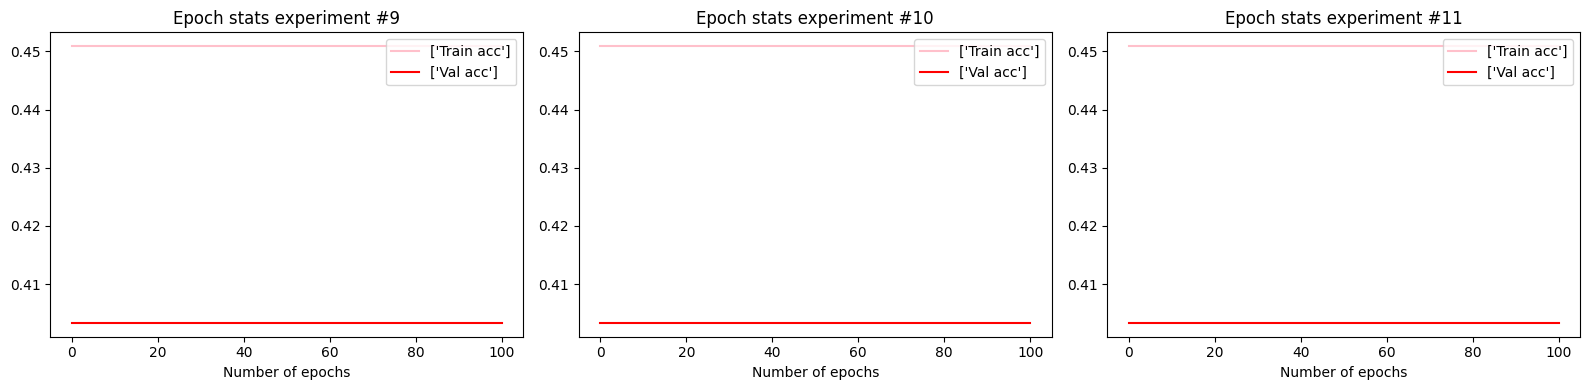

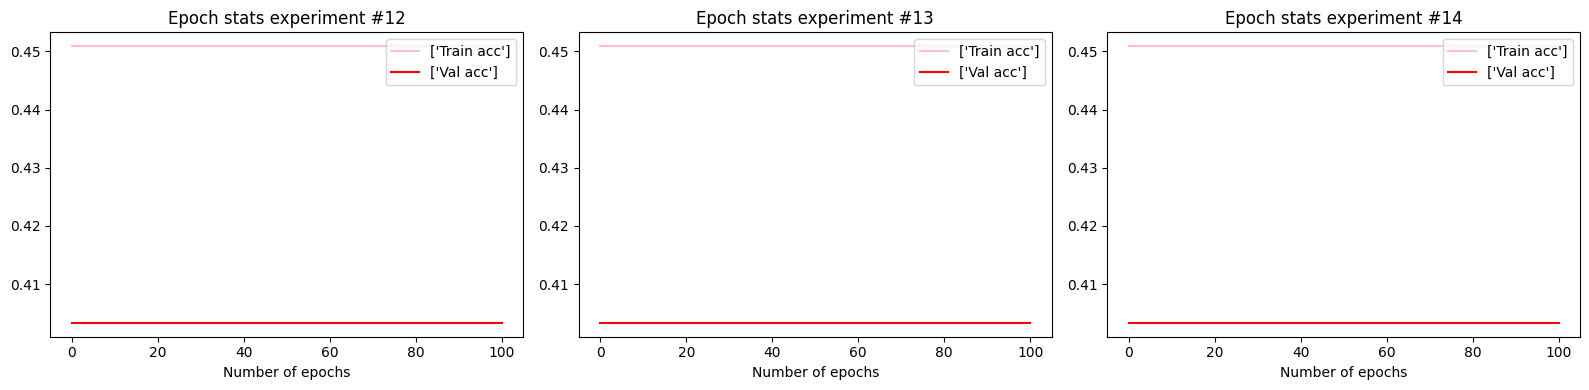

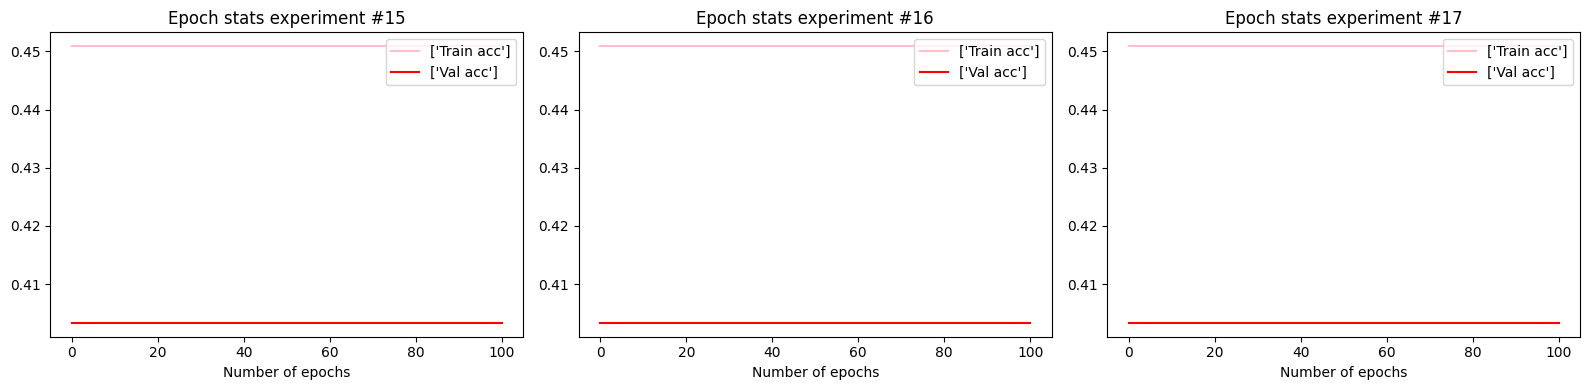

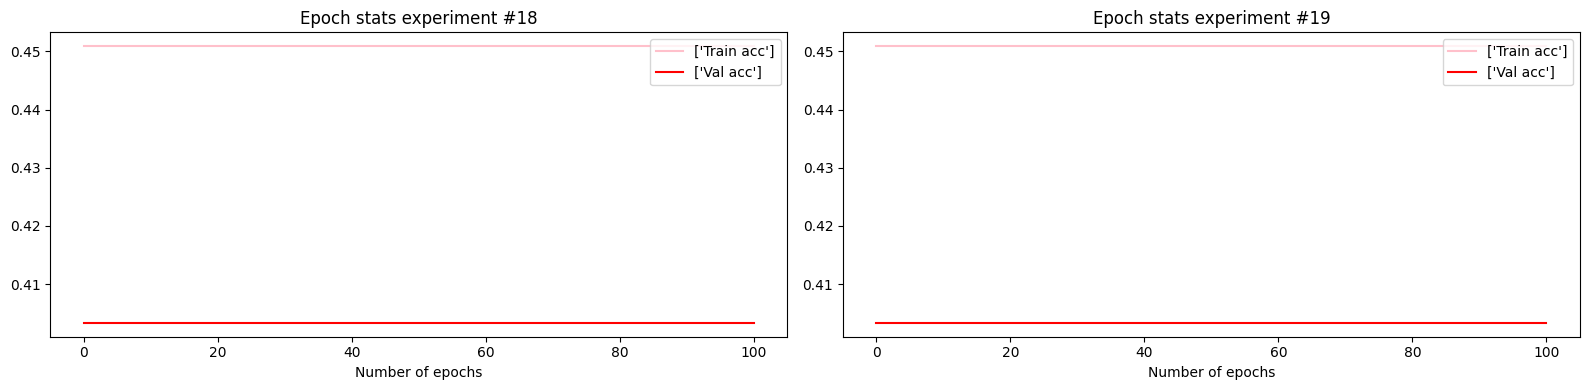

In [36]:
display_epochs_stats(deepsetv2_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### FeedForward

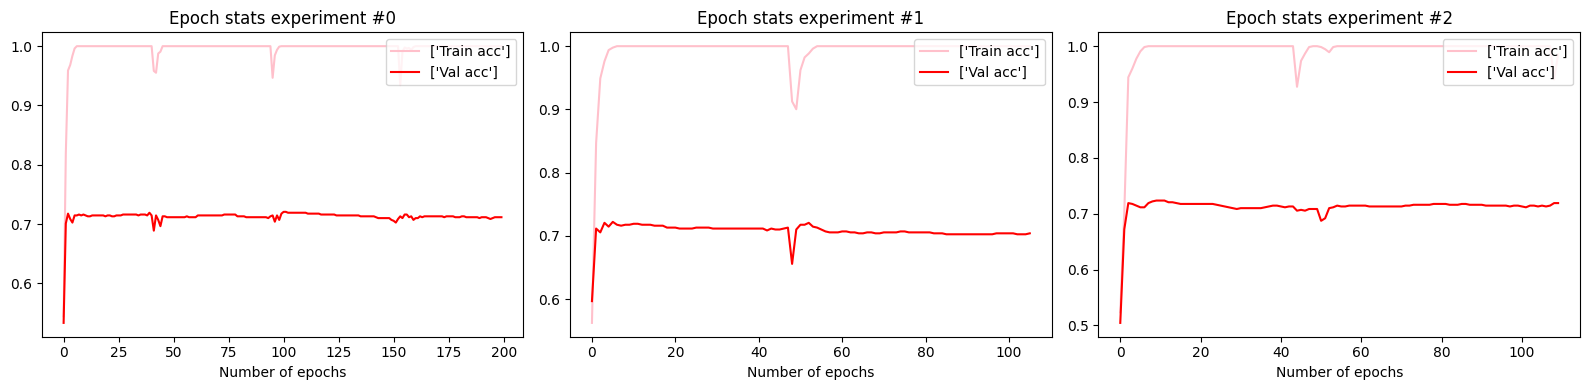

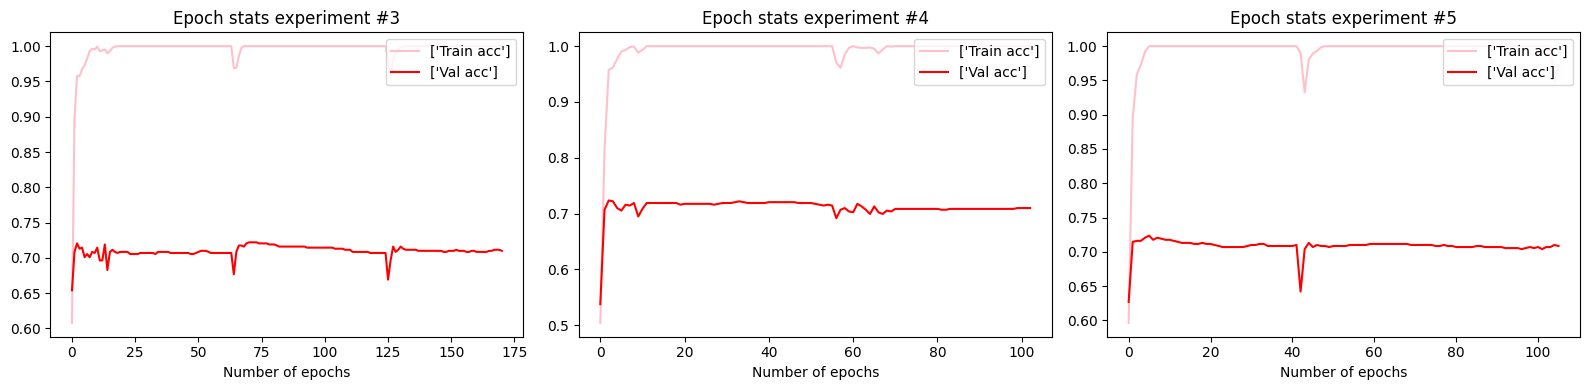

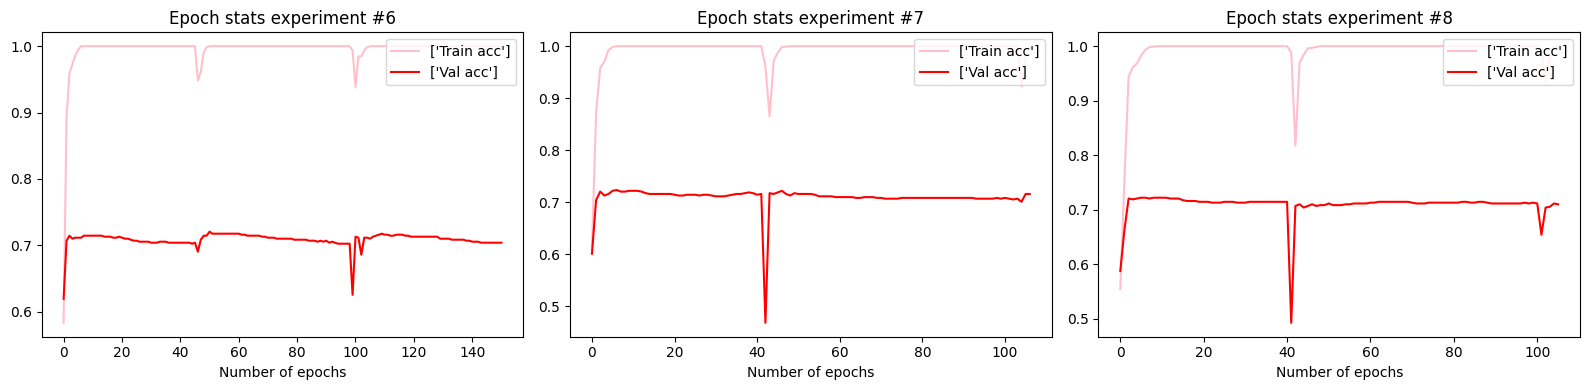

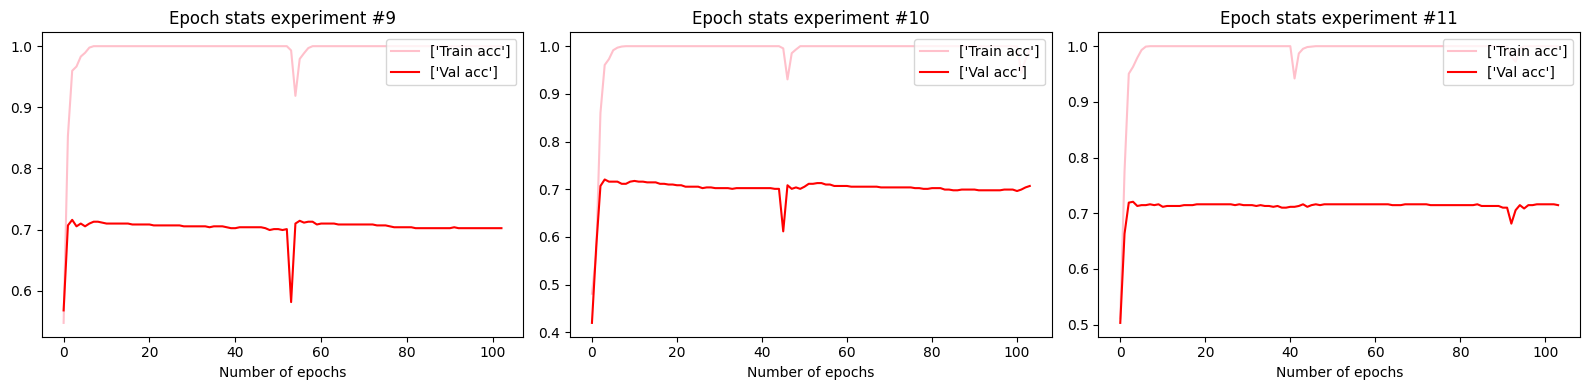

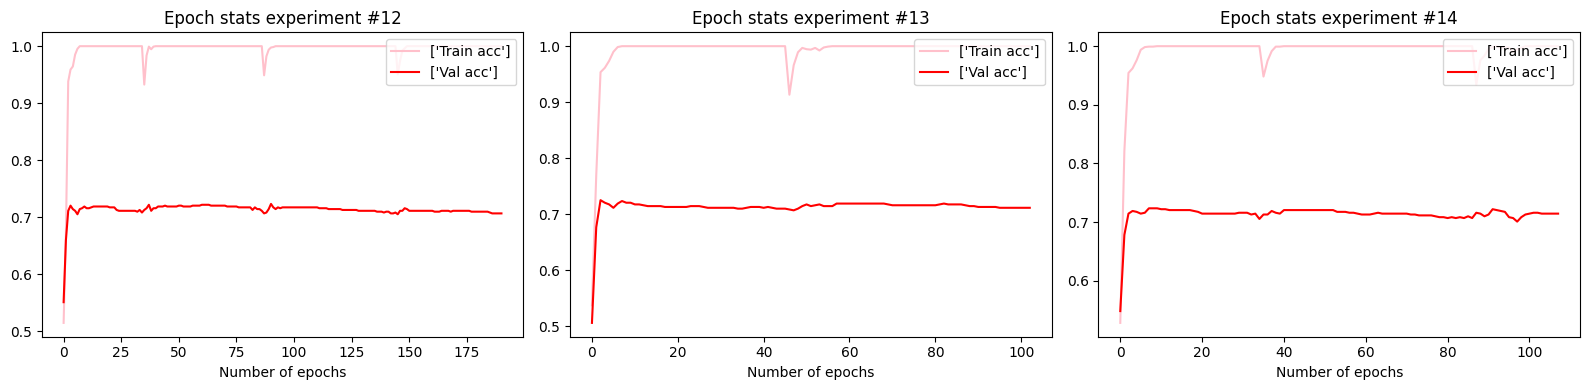

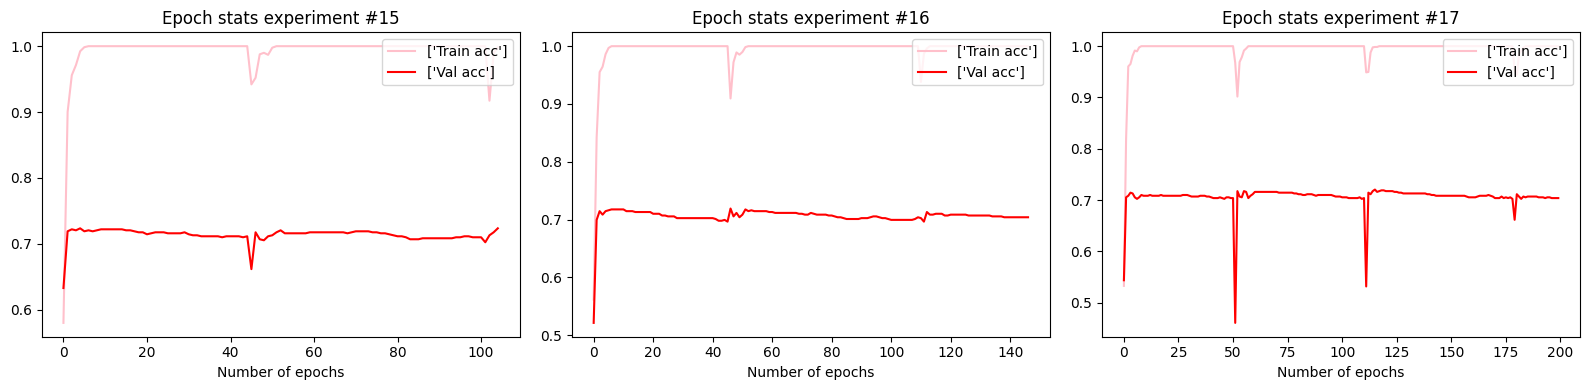

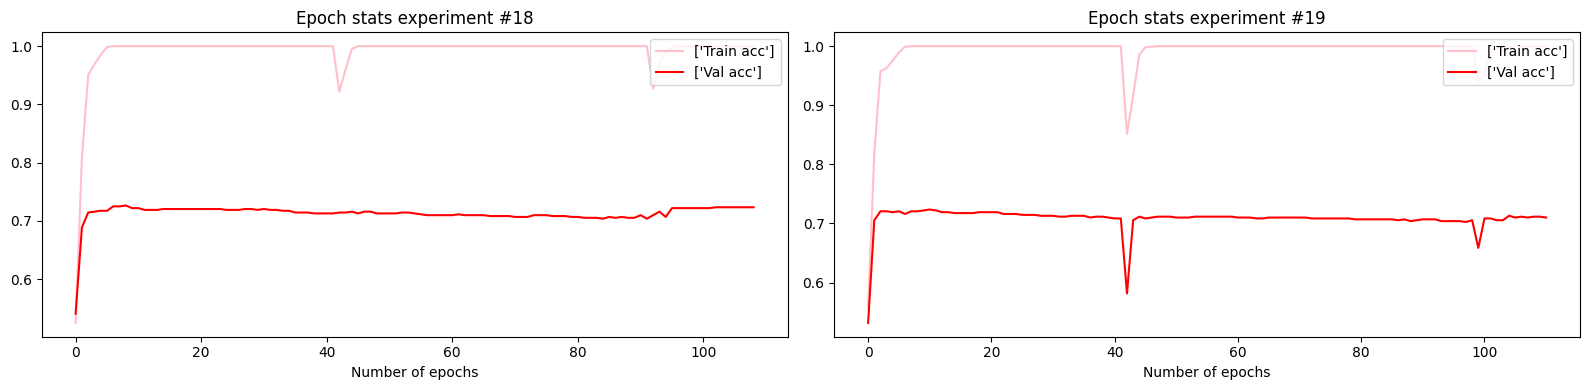

In [37]:
display_epochs_stats(feedforward_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

# Best performing models

In [38]:
best_lstm_model = LSTM_Model(data, 16, 16, 8).to(device)
best_lstm_model.load_state_dict(torch.load('best_LSTM_model_' + experiment_name))
best_cnn_model = CNN_Model(data, 32, 64, 4, -1,).to(device)
best_cnn_model.load_state_dict(torch.load('best_CNN_model_' + experiment_name))
best_deepset_model = DEEPSET_Model(data).to(device)
best_deepset_model.load_state_dict(torch.load('best_DEEPSET_model_' + experiment_name))
best_deepsetv2_model = DEEPSETV2_Model(data).to(device)
best_deepsetv2_model.load_state_dict(torch.load('best_DEEPSETV2_model_' + experiment_name))
best_feedforward_model = FEEDFORWARD_Model(data).to(device)
best_feedforward_model.load_state_dict(torch.load('best_FEEDFORWARD_model_' + experiment_name))

RuntimeError: Error(s) in loading state_dict for LSTM_Model:
	size mismatch for densef1_1.weight: copying a param with shape torch.Size([32, 16]) from checkpoint, the shape in current model is torch.Size([16, 16]).
	size mismatch for densef1_1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for densef2_1.weight: copying a param with shape torch.Size([32, 16]) from checkpoint, the shape in current model is torch.Size([16, 16]).
	size mismatch for densef2_1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for densef3_1.weight: copying a param with shape torch.Size([32, 16]) from checkpoint, the shape in current model is torch.Size([16, 16]).
	size mismatch for densef3_1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for densef1_2.weight: copying a param with shape torch.Size([8, 32]) from checkpoint, the shape in current model is torch.Size([8, 16]).
	size mismatch for densef2_2.weight: copying a param with shape torch.Size([8, 32]) from checkpoint, the shape in current model is torch.Size([8, 16]).
	size mismatch for densef3_2.weight: copying a param with shape torch.Size([8, 32]) from checkpoint, the shape in current model is torch.Size([8, 16]).

## Top wrong predictions for best performing CNN model

In [ ]:
print_wrong_preds([get_wrong_predictions(best_cnn_model, x_test_cnn, y_test, test_original)], top_k=10)

Top 10 false positives: 

._,.w_,u_,_._.,, d.,r.__,.,.,..,. | label: False | actual prediction: 0.9767375588417053
.._..w..u,,..,.. _d_.r,_,,,,.,__, | label: False | actual prediction: 0.9745071530342102
_,,,,wu,,,,.,.._ dr,___,,,_.,,_., | label: False | actual prediction: 0.9744225740432739
,__.,___,,_w.,u_ .,,_.,d_,r,_,_,. | label: False | actual prediction: 0.9680578112602234
_,,,.w..u__,__,_ d..r,..,,,,,,,,. | label: False | actual prediction: 0.9678236842155457
.__w.,u.__.____, _._d..r,_.,,,.., | label: False | actual prediction: 0.9663006067276001
.w,.u___.,_.,.., ,__,_d,,r,_,..,. | label: False | actual prediction: 0.9643228650093079
,w_.u..,,__,,__, .d..r.,_,,,._,_, | label: False | actual prediction: 0.961966872215271
,_._,wu,,..,_._. ,._dr,_.,_._.,,. | label: False | actual prediction: 0.9619213342666626
__,,_._w,_u..,_. _,,,..d,,r,_..,_ | label: False | actual prediction: 0.9596861600875854

Top 10 false negatives: 

__...,_.._._uw,. .._,_.,__,.__,dr | label: True | actual p

## Top wrong predictions for best performing LSTM model

In [ ]:
print_wrong_preds([get_wrong_predictions(best_lstm_model, x_test_lstm, y_test, test_original)], top_k=10)

Top 10 false positives: 

_,_,,,,_wu.,_.,. ,,,,,,.,,,.__,dr | label: False | actual prediction: 0.817249596118927
.____..,___wu.,_ .,.,___,.,..,,dr | label: False | actual prediction: 0.7875151038169861
_.__,..,._.w,_u. ,,.,__,.,_.,d_,r | label: False | actual prediction: 0.7200707197189331
.,,.__.__,._,,wu ..,,._...._.__dr | label: False | actual prediction: 0.6989848613739014
_..,,.,.,wu,.._. ,__,,,,.__,.._dr | label: False | actual prediction: 0.6889504194259644
,,_.___.,,._w..u _..,,_..,,__d,,r | label: False | actual prediction: 0.6478376984596252

Top 10 false negatives: 

..___...,_,.wu,. ,,,_...,.._,_,.r | label: True | actual prediction: 0.004094685427844524
,,_,.___..wu.... _,._,,_,__,,_,r_ | label: True | actual prediction: 0.011520251631736755
_,_.__.,,,,wu_._ ,,_,.,.,..,_...r | label: True | actual prediction: 0.015230796299874783
,__.,_.._wu._,., ,,_.,___.,.__._r | label: True | actual prediction: 0.02120811864733696
,.,,_._._,wu,.,. ...,,....,_,.__r | label: True | actua

## Top wrong predictions for best performing DeepSets V1 model

In [ ]:
print_wrong_preds([get_wrong_predictions(best_deepset_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

wu___._...,.___, ___,__dr,,,_,.,_ | label: False | actual prediction: 0.9895008206367493
,,,wu_._,....._. dr_..__,,___,,.. | label: False | actual prediction: 0.988716185092926
,__wu_.___,.__,, _,_.dr,....,.... | label: False | actual prediction: 0.9873530864715576
,,_.w_,u..,..__, .d,,r..,_,,._,__ | label: False | actual prediction: 0.9855164885520935
wu_......_._,._, ,,dr..,_,,_,_,,. | label: False | actual prediction: 0.9794061779975891
.,wu__,,,,_..,,, ._._.dr_,,..,__, | label: False | actual prediction: 0.9790955781936646
,,wu_,_...,..,,, _dr_,,_,_..,_.__ | label: False | actual prediction: 0.9787712693214417
_.wu_.,.___.,,,_ ,_.,__dr_,,_._.. | label: False | actual prediction: 0.9731114506721497
wu_.,_,,_.___,,, ..._dr._._,.,.._ | label: False | actual prediction: 0.9703298211097717
.__w.,u.__.____, _._d..r,_.,,,.., | label: False | actual prediction: 0.9687817096710205

Top 10 false negatives: 

__,,,,.wu.,_.,.. ,_.,..,,_____r__ | label: True | actual p

## Top wrong predictions for best performing DeepSets V2 model

In [ ]:
print_wrong_preds([get_wrong_predictions(best_deepsetv2_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 


Top 10 false negatives: 

.,_,_,_,,,,uw_,. ._,.___..._,,_.r | label: True | actual prediction: 0.5
,_wu.,,,___,_,_. ,,_._r.,___.,,_, | label: True | actual prediction: 0.5
,..__,_._wu.,,_. _,,_...,,_.r__.. | label: True | actual prediction: 0.5
,._._u..w._,_,., __,r,.._,_.,__.. | label: True | actual prediction: 0.5
.,___uw...,...,, ,,..,__r__,,.._, | label: True | actual prediction: 0.5
,_.,..,.___,._,, ._..,_,,,._,,r.. | label: True | actual prediction: 0.5
_.,._.,w..u,.,,. _...,....r__,.._ | label: True | actual prediction: 0.5
_,..__._____.uw, .,._,,..,..,,r.. | label: True | actual prediction: 0.5
,..,,_.w_._,_.__ ,.,,_,_,d.,r_.., | label: True | actual prediction: 0.5
_,_.___.,,__w,,u _,,_,,,,..__r_,, | label: True | actual prediction: 0.5




## Top wrong predictions for best performing Feedforward model

In [ ]:
print_wrong_preds([get_wrong_predictions(best_feedforward_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

,__wu_.___,.__,, _,_.dr,....,.... | label: False | actual prediction: 0.9670752286911011
wu_,....,....._, _dr...,.,.,..._. | label: False | actual prediction: 0.9553406238555908
,,wu_,_...,..,,, _dr_,,_,_..,_.__ | label: False | actual prediction: 0.9546793699264526
wu_......_._,._, ,,dr..,_,,_,_,,. | label: False | actual prediction: 0.9544191956520081
wu___._...,.___, ___,__dr,,,_,.,_ | label: False | actual prediction: 0.9525313377380371
,__,.w..u,_._,,, ___d,,r,,,___,.. | label: False | actual prediction: 0.9490067958831787
wu_.,_,,_.___,,, ..._dr._._,.,.._ | label: False | actual prediction: 0.9466859698295593
.wu_..,,._,,,_,, _dr._,,,_,__,___ | label: False | actual prediction: 0.9440601468086243
.__,,_wu_.,.,_,_ ._..dr,__._,,.._ | label: False | actual prediction: 0.9397515654563904
w__u_,.___,.__,_ .,,d,_r..._._._. | label: False | actual prediction: 0.9391787052154541

Top 10 false negatives: 

,.,_,__uw_,_.,__ __,,.,,...dr__,_ | label: True | actual 

# Saving Notebook State

In [ ]:
import dill
dill.dump_session('notebook_env_' + experiment_name + '.db')

ModuleNotFoundError: No module named 'dill'

# Loading Notebook State

In [ ]:
import dill
experiment_name = "f2_f4_redo"
# dill.load_session('notebook_env_' + experiment_name + '.db')